# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [ ]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

<h2 style="text-align: center;"><b>Нейрон с ReLU (Recitified Linear Unit)</b></h2>  

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu_item(x):
    return 0 if x <= 0 else x

In [ ]:
def relu(x):
    return np.apply_along_axis(relu_item, 1, x)

In [ ]:
def relu_derivative(x):
     return 1 if x > 0 else 0

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        relu_gradient = (X @ self.w + self.b) > 0
        self.w = self.w - learning_rate * (X.T @ (relu_gradient * (X @ self.w + self.b - y))) / n
        self.b = self.b - learning_rate * np.mean(relu_gradient * (X @ self.w + self.b - y))

        
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

    def predict(self, X, threshold=0.5):
      y_res = (self.forward_pass(X) > threshold)
      return y_res

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

## Начнем с яблок и груш

In [ ]:
!gdown 1cXqPvM3Z8Bnt7aj_XjxASzh-8oQ9rmxS

Downloading...
From: https://drive.google.com/uc?id=1cXqPvM3Z8Bnt7aj_XjxASzh-8oQ9rmxS
To: /content/apples_pears.csv
100% 43.6k/43.6k [00:00<00:00, 33.4MB/s]


In [ ]:
data = pd.read_csv("apples_pears.csv")

## Получаем информацию о датасете

In [ ]:
data.info

<bound method DataFrame.info of      yellowness  symmetry  target
0      0.779427  0.257305     1.0
1      0.777005  0.015915     1.0
2      0.977092  0.304210     1.0
3      0.043032  0.140899     0.0
4      0.760433  0.193123     1.0
..          ...       ...     ...
995    0.288482  0.051186     0.0
996    0.892424  0.795257     0.0
997    0.927219  0.134986     1.0
998    0.015830  0.481322     0.0
999    0.967964  0.308571     1.0

[1000 rows x 3 columns]>

In [ ]:
data.columns

Index(['yellowness', 'symmetry', 'target'], dtype='object')

In [ ]:
data.describe

<bound method NDFrame.describe of      yellowness  symmetry  target
0      0.779427  0.257305     1.0
1      0.777005  0.015915     1.0
2      0.977092  0.304210     1.0
3      0.043032  0.140899     0.0
4      0.760433  0.193123     1.0
..          ...       ...     ...
995    0.288482  0.051186     0.0
996    0.892424  0.795257     0.0
997    0.927219  0.134986     1.0
998    0.015830  0.481322     0.0
999    0.967964  0.308571     1.0

[1000 rows x 3 columns]>

In [ ]:
data.head(5)

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


## Визуализация данных

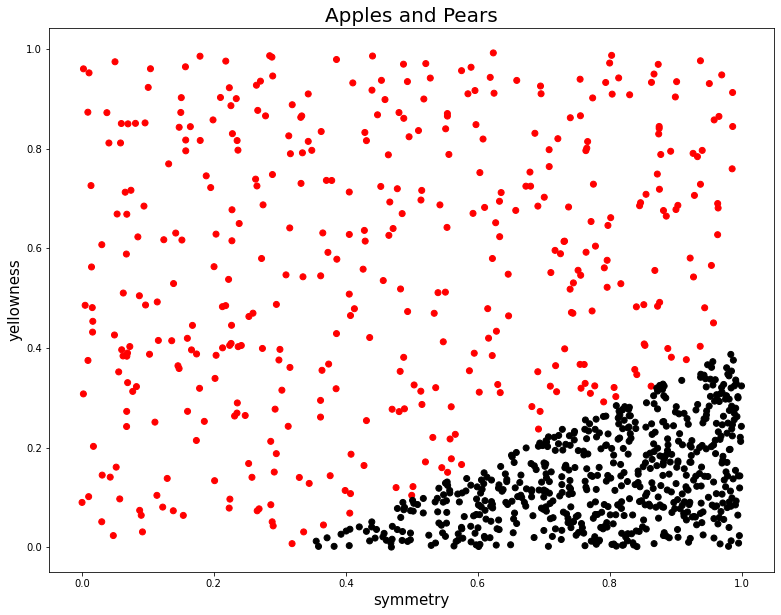

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='flag')
plt.title('Apples and Pears', fontsize=20)
plt.xlabel('symmetry', fontsize=15)
plt.ylabel('yellowness', fontsize=15)
plt.show()

In [ ]:
X = data.iloc[:,:2].values  
y = data['target'].values.reshape((-1, 1)) 

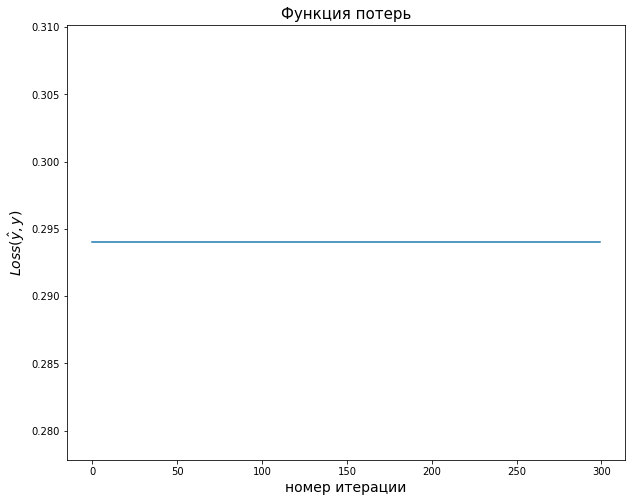

CPU times: user 1.28 s, sys: 12.6 ms, total: 1.3 s
Wall time: 1.31 s


In [ ]:
%%time

neuron = NeuronReLU()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

## Для удобства продублируем реализацию

In [ ]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        relu_gradient = (X @ self.w + self.b) > 0
        self.w = self.w - learning_rate * (X.T @ (relu_gradient * (X @ self.w + self.b - y))) / n
        self.b = self.b - learning_rate * np.mean(relu_gradient * (X @ self.w + self.b - y))

        
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        #self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        #self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

    def predict(self, X, threshold=0.5):
      y_res = (self.forward_pass(X) > threshold)
      return y_res

### Протестируем с 10000 эпохами

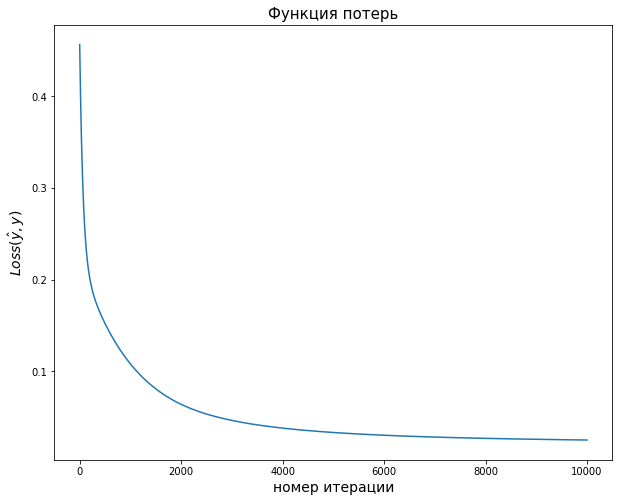

CPU times: user 33 s, sys: 801 ms, total: 33.8 s
Wall time: 33.1 s


In [ ]:
%%time

neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим на результаты обучения нейрона

### threshold = 0.5

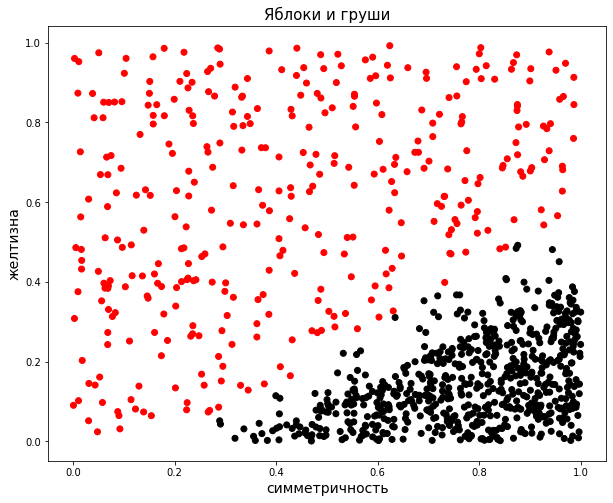

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X), cmap='flag')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X)))
print("f1 score: ", f1_score(y, neuron.predict(X)))

accuracy score:  0.951
f1 score:  0.9600000000000001


### threshold = 0.3

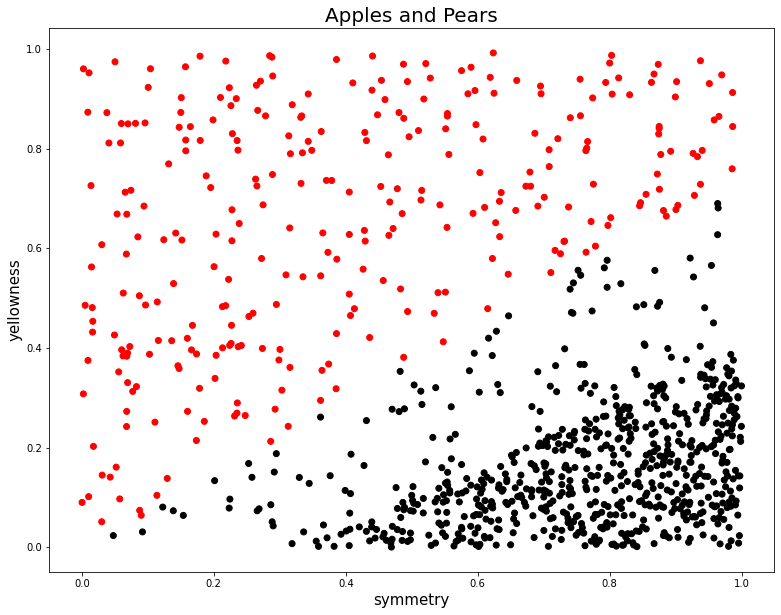

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X, threshold=0.3), cmap='flag')
plt.title('Apples and Pears', fontsize=20)
plt.xlabel('symmetry', fontsize=15)
plt.ylabel('yellowness', fontsize=15)
plt.show()

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X, threshold=0.3)))
print("f1 score: ", f1_score(y, neuron.predict(X, threshold=0.3)))

accuracy score:  0.891
f1 score:  0.9151750972762646


### threshold = 0.7

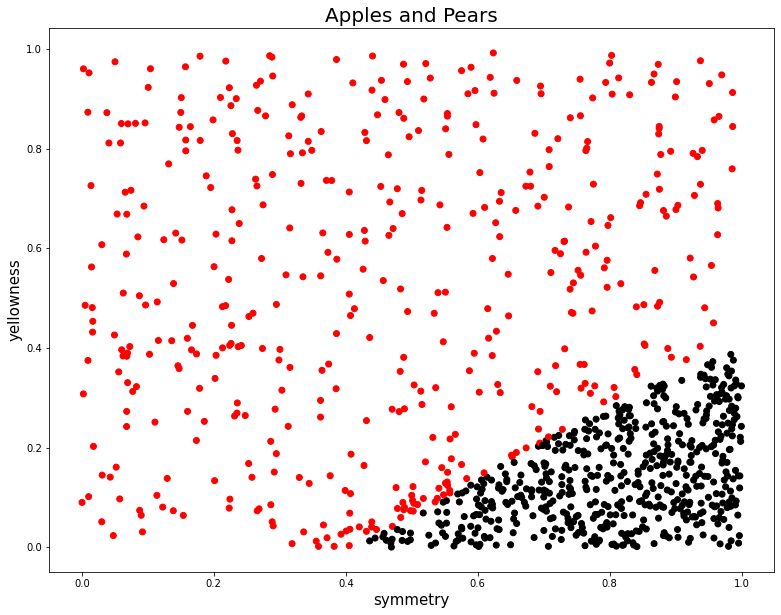

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X, threshold=0.7), cmap='flag')
plt.title('Apples and Pears', fontsize=20)
plt.xlabel('symmetry', fontsize=15)
plt.ylabel('yellowness', fontsize=15)
plt.show()

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X, threshold=0.7)))
print("f1 score: ", f1_score(y, neuron.predict(X, threshold=0.7)))

accuracy score:  0.956
f1 score:  0.9611992945326279


Лучшие значения метрик accuracy_score и f1_score нейрон с функицей активации Relu получил при threshold = 0.7.
Accuracy score:  0.956. f1 score:  0.961


## Теперь приступим к Голосу

In [ ]:
!gdown 1rUTURdK0u3VMvi8n09R2HMDbuk4RC7jS

Downloading...
From: https://drive.google.com/uc?id=1rUTURdK0u3VMvi8n09R2HMDbuk4RC7jS
To: /content/voice.csv
100% 1.07M/1.07M [00:00<00:00, 131MB/s]


In [ ]:
data = pd.read_csv("voice.csv")

## Получим информацию о датасете

In [ ]:
data.info

<bound method DataFrame.info of       meanfreq        sd    median       Q25       Q75       IQR       skew  \
0     0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1     0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2     0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3     0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4     0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   
...        ...       ...       ...       ...       ...       ...        ...   
3163  0.131884  0.084734  0.153707  0.049285  0.201144  0.151859   1.762129   
3164  0.116221  0.089221  0.076758  0.042718  0.204911  0.162193   0.693730   
3165  0.142056  0.095798  0.183731  0.033424  0.224360  0.190936   1.876502   
3166  0.143659  0.090628  0.184976  0.043508  0.219943  0.176435   1.591065   
3167  0.165509  0.092884  0.183044  0.070072  0.250827  0.180756   1.705029   

             kurt  

In [ ]:
data.shape

(3168, 21)

In [ ]:
data.describe

<bound method NDFrame.describe of       meanfreq        sd    median       Q25       Q75       IQR       skew  \
0     0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1     0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2     0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3     0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4     0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   
...        ...       ...       ...       ...       ...       ...        ...   
3163  0.131884  0.084734  0.153707  0.049285  0.201144  0.151859   1.762129   
3164  0.116221  0.089221  0.076758  0.042718  0.204911  0.162193   0.693730   
3165  0.142056  0.095798  0.183731  0.033424  0.224360  0.190936   1.876502   
3166  0.143659  0.090628  0.184976  0.043508  0.219943  0.176435   1.591065   
3167  0.165509  0.092884  0.183044  0.070072  0.250827  0.180756   1.705029   

             kurt

In [ ]:
data.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [ ]:
data.head(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Предобработка и подготовка данных

In [ ]:
import pandas as pd
from sklearn import preprocessing

data["label"] = data["label"].apply(lambda x: 1 if x == 'male' else 0)
min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data))
data = data.sample(frac=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train = data.iloc[:int(len(data)*0.7), :-1] 
y_train = data.iloc[:int(len(data)*0.7), -1]  

X_test = data.iloc[int(len(data)*0.7):, :-1] 
y_test = data.iloc[int(len(data)*0.7):, -1] 

## Обучение модели

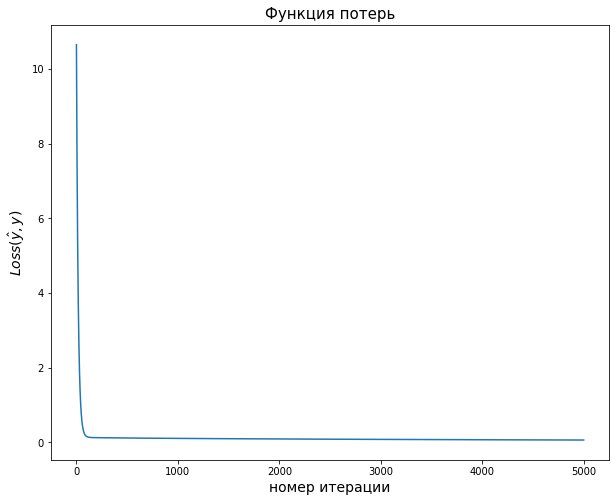

In [ ]:
neuronReLU = NeuronReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values = neuronReLU.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

## Оценим качество предсказания модели

### threshold = 0.5

In [ ]:
y_predictions = neuronReLU.predict(X_test.values)
y_predictions_map = np.array(list(map(lambda x: 1. if x else 0., y_predictions.ravel()))).reshape(-1, 1)

print('Accuracy score Relu threshold = 0.5: {:.3f} %'.format(
    accuracy_score(y_test, y_predictions_map) * 100))
print('f1 score Relu threshold = 0.5: {:.3f} %'.format(
    f1_score(y_test, y_predictions_map) * 100))

Accuracy score Relu threshold = 0.5: 88.854 %
f1 score Relu threshold = 0.5: 88.981 %


## Подберем параметр treshhold

In [ ]:
evaluations_acc = []
evaluations_f1 = []
for threshold in list(np.arange(0.1, 1.0, 0.05)):
    y_predictions = neuronReLU.predict(X_test.values, threshold=threshold)
    y_predictions_map = np.array(list(map(lambda x: 1. if x else 0., y_predictions.ravel()))).reshape(-1, 1)
    evaluations_acc.append([accuracy_score(y_test, y_predictions_map) * 100, threshold])
    evaluations_f1.append([f1_score(y_test, y_predictions_map) * 100, threshold])

best_eval_acc = max(evaluations_acc)
best_eval_f1 = max(evaluations_f1)
print('Best accuracy_score and threshold', best_eval_acc[0], best_eval_acc[1])
print('Best f1_score and threshold', best_eval_f1[0], best_eval_f1[1])

Best accuracy_score and threshold 88.85383806519454 0.5000000000000001
Best f1_score and threshold 88.98128898128897 0.5000000000000001


### Наибольшее значение метрики accuracy_score получили при treshold равном 0.5. Это значение равно:

In [ ]:
y_predictions = neuronReLU.predict(X_test.values, best_eval_acc[1])
y_predictions_map = np.array(list(map(lambda x: 1. if x else 0., y_predictions.ravel()))).reshape(-1, 1)

print('Accuracy score: {:.3f} %'.format(
    accuracy_score(y_test, y_predictions_map) * 100))
print('f1 score: {:.3f} %'.format(
    f1_score(y_test, y_predictions_map) * 100))

Accuracy score: 88.854 %
f1 score: 88.981 %


Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

#Leaky ReLU

<h2 style="text-align: center;"><b>Нейрон с LeakyReLU (Leaky Recitified Linear Unit)</b></h2>  

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [ ]:
def leaky_relu_item(x, alpha=0.01):
    return alpha*x if x <= 0 else x

In [ ]:
def leaky_relu(X, alpha=0.01):
    """LeakyReLU-функция"""
    return np.apply_along_axis(leaky_relu_item, 1, X)

In [ ]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return alpha if x <= 0 else 1

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0, alpha=0.01):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        self.alpha = alpha
        
        
    def activate(self, x):
       return leaky_relu(x, self.alpha)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        leaky_relu_gradient_w = np.zeros((X.shape[1], 1))
        leaky_relu_gradient_b = 0.

        for i in range(len(X)):
            x_i = X[i].reshape(1, -1)

            if y_pred[i] <= 0:
                leaky_relu_gradient_w = leaky_relu_gradient_w + self.alpha * x_i.T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
                leaky_relu_gradient_b += self.alpha * (y_pred[i][0] - y[i][0])

            else:
                leaky_relu_gradient_w = leaky_relu_gradient_w + x_i.T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
                leaky_relu_gradient_b += y_pred[i][0] - y[i][0]
        
        leaky_relu_gradient_w /= n
        leaky_relu_gradient_b /= n
        self.w = self.w - learning_rate * leaky_relu_gradient_w
        self.b = self.b - learning_rate * leaky_relu_gradient_b

    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
#         self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
#         self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            Loss_values.append(Loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)
        
        return Loss_values

    def predict(self, X, threshold=0.5):
      y_res = (self.forward_pass(X) > threshold)
      return y_res

## Протестируем на яблоках и грушах

In [ ]:
data = pd.read_csv("apples_pears.csv")
X = data.iloc[:,:2].values  
y = data['target'].values.reshape((-1, 1)) 

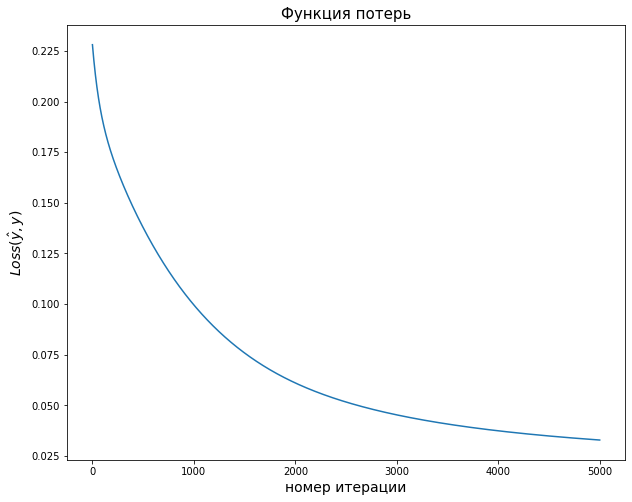

In [ ]:
neuron = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

### threshold=0.5

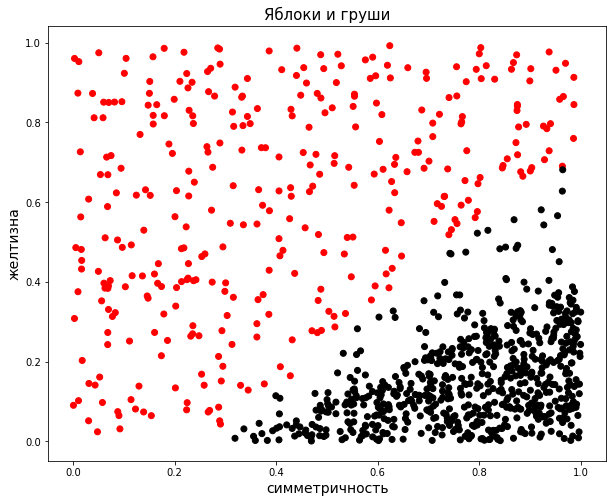

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X), cmap='flag')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X)))
print("f1 score: ", f1_score(y, neuron.predict(X)))

accuracy score:  0.936
f1 score:  0.9483870967741935


### threshold=0.3

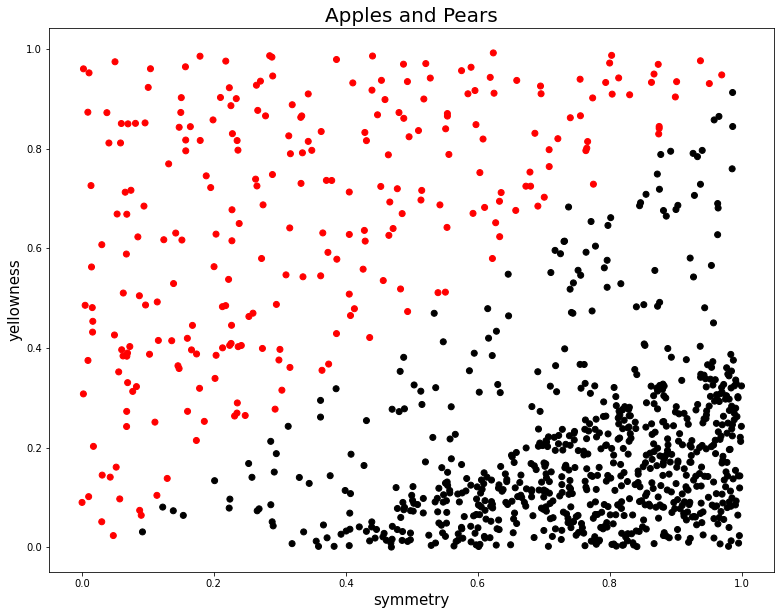

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X, threshold=0.3), cmap='flag')
plt.title('Apples and Pears', fontsize=20)
plt.xlabel('symmetry', fontsize=15)
plt.ylabel('yellowness', fontsize=15)
plt.show()

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X, threshold=0.3)))
print("f1 score: ", f1_score(y, neuron.predict(X, threshold=0.3)))

accuracy score:  0.851
f1 score:  0.8875471698113209


### threshold = 0.7

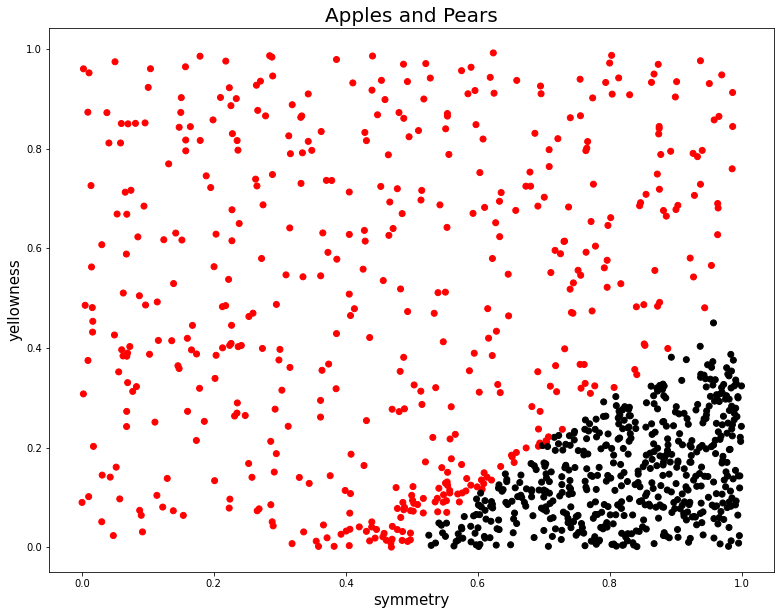

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=neuron.predict(X, threshold=0.7), cmap='flag')
plt.title('Apples and Pears', fontsize=20)
plt.xlabel('symmetry', fontsize=15)
plt.ylabel('yellowness', fontsize=15)
plt.show()

In [ ]:
print("accuracy score: ", accuracy_score(y, neuron.predict(X, threshold=0.7)))
print("f1 score: ", f1_score(y, neuron.predict(X, threshold=0.7)))

accuracy score:  0.915
f1 score:  0.923076923076923


Лучшие значения метрик accuracy_score и f1_score нейрон с функицей активации LeakyRelu получил при threshold = 0.7. Accuracy score: 0.936. f1 score: 0.948

### Голос

In [ ]:
data = pd.read_csv("voice.csv")

In [ ]:
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data))
data = data.sample(frac=1)

In [ ]:
X_train = data.iloc[:int(len(data)*0.7), :-1] 
y_train = data.iloc[:int(len(data)*0.7), -1] 

X_test = data.iloc[int(len(data)*0.7):, :-1]
y_test = data.iloc[int(len(data)*0.7):, -1] 

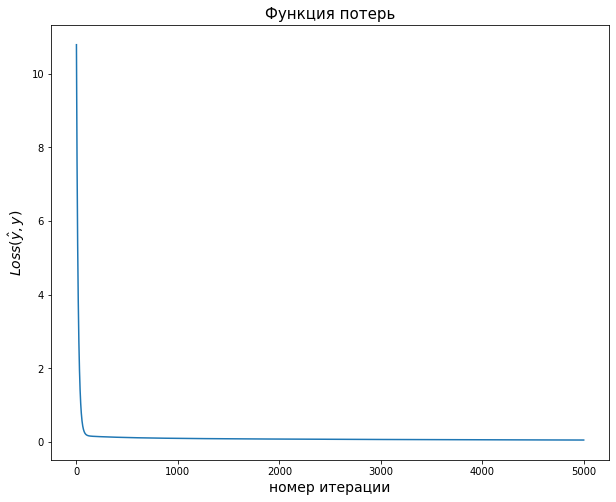

In [ ]:
neuronLeakyReLU = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values = neuronLeakyReLU.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

### Подберем threshold

In [ ]:
evaluations_acc = []
evaluations_f1 = []
for threshold in list(np.arange(0.1, 1.0, 0.05)):
    y_predictions = neuronReLU.predict(X_test.values, threshold=threshold)
    y_predictions_map = np.array(list(map(lambda x: 1. if x else 0., y_predictions.ravel()))).reshape(-1, 1)
    evaluations_acc.append([accuracy_score(y_test, y_predictions_map) * 100, threshold])
    evaluations_f1.append([f1_score(y_test, y_predictions_map) * 100, threshold])

best_eval_acc = max(evaluations_acc)
best_eval_f1 = max(evaluations_f1)
print('Best accuracy_score and threshold', best_eval_acc[0], best_eval_acc[1])
print('Best f1_score and threshold', best_eval_f1[0], best_eval_f1[1])

Best accuracy_score and threshold 89.27444794952682 0.45000000000000007
Best f1_score and threshold 89.99999999999999 0.45000000000000007


In [ ]:
y_predictions = neuronReLU.predict(X_test.values, best_eval_acc[1])
y_predictions_map = np.array(list(map(lambda x: 1. if x else 0., y_predictions.ravel()))).reshape(-1, 1)

print('Accuracy score: {:.3f} %'.format(
    accuracy_score(y_test, y_predictions_map) * 100))
print('f1 score: {:.3f} %'.format(
    f1_score(y_test, y_predictions_map) * 100))

Accuracy score: 89.274 %
f1 score: 90.000 %


Нейрон с функцией активации LeakyReLU показал более высокое значение показателя accuracy_score.

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

#ELU

<h2 style="text-align: center;"><b>Нейрон с ELU (Exponential Linear Unit)</a></b></h2>  

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [ ]:
def eelu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return

In [ ]:
def elu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    <Ваш код здесь>

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        <Ваш код здесь>
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        <Ваш код здесь>
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        <Ваш код здесь>
    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
#         self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
#         self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            <Ваш код здесь>
        
        return Loss_values

**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU